<a href="https://colab.research.google.com/github/hosngholami/RecommenderSystem/blob/main/RecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install opendatasets
!pip install geopy
!pip install folium
!pip install -U pymoo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=f48510dc4b862c0800b57bc16803527b0d46bbdbf3695eb2b4c798c661fc46c0
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [4]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors

pd.set_option("display.max_columns", 1000)
pd.set_option('display.max_rows', 1000)

In [ ]:
tag

,Unnamed: 0,Id,Title,Title:Fn
0,0,1,Historical,مکان‌های تاریخی مانند آثار باستانی و معماری قد...
1,1,2,Recreational,مکان‌های تفریحی مانند پارک‌ها، شهربازی‌ها و مر...
2,2,3,Natural,جاذبه‌های طبیعی مانند کوه‌ها، جنگل‌ها، دریاها ...
3,3,4,Adventure,مکان‌های ماجراجویانه (مانند کوه‌نوردی، صخره‌نو...
4,4,5,Religious,مکان‌های مذهبی (مانند کلیساها، مساجد، معابد).
5,5,6,Health/Thermal,مکان‌های سلامت و درمانی مانند چشمه‌های آب گرم
6,6,7,Resort,استراحتگاه.
7,7,8,Artistic,مکان‌هایی هنری مانند گالری‌ها، موزه‌ها و مناظر...
8,8,9,Photography,مکان های مناسب عکاسی مانند گالری، موزه ها و م...
9,9,10,Cultural,مکان‌هایی که فرهنگ و هنر یک منطقه را نمایش می‌...


In [ ]:
preference = pd.read_csv('/content/drive/MyDrive/Shiraz/preference.csv')
group = pd.read_csv('/content/drive/MyDrive/Shiraz/group.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Shiraz/group.csv'

,Unnamed: 0,Id,Title,Title:Fn
0,0,1,Historical,مکان‌های تاریخی مانند آثار باستانی و معماری قد...
1,1,2,Recreational,مکان‌های تفریحی مانند پارک‌ها، شهربازی‌ها و مر...
2,2,3,Natural,جاذبه‌های طبیعی مانند کوه‌ها، جنگل‌ها، دریاها ...
3,3,4,Adventure,مکان‌های ماجراجویانه (مانند کوه‌نوردی، صخره‌نو...
4,4,5,Religious,مکان‌های مذهبی (مانند کلیساها، مساجد، معابد).
5,5,6,Health/Thermal,مکان‌های سلامت و درمانی مانند چشمه‌های آب گرم
6,6,7,Resort,استراحتگاه.
7,7,8,Artistic,مکان‌هایی هنری مانند گالری‌ها، موزه‌ها و مناظر...
8,8,9,Photography,مکان های مناسب عکاسی مانند گالری، موزه ها و م...
9,9,10,Cultural,مکان‌هایی که فرهنگ و هنر یک منطقه را نمایش می‌...


In [ ]:
group = pd.DataFrame(columns=["Id", "StartData", "EndDate", "Budget"])

In [ ]:
preference = pd.DataFrame(columns=["Id", "GroupId", "UserId", "Preference"])

In [ ]:
preference.to_csv('/content/drive/MyDrive/Shiraz/preference.csv')

In [ ]:
preference

,Id,GroupId,UserId,Preference


In [ ]:
tag = pd.DataFrame(columns=["Id", "Title", "Title:Fn"])

In [ ]:
data = [{
    "Id": 1,
    "GroupId": 1,
    "UserId": 1,
    "Preference": {"historic" : 3, "Resort": 1, "Natural": 5}
}]

In [ ]:
preference = pd.DataFrame(data)
preference.to_csv('/content/drive/MyDrive/Shiraz/preference.csv')

In [ ]:
grouped = preference.groupby('GroupId')

In [ ]:

for name, group in grouped:
  if (len(group) > 1):
    preferenceList = {}
    for preference in group['Preference']:
      for p in preference:
        if(p not in preferenceList):
          preferenceList[p] = preference[p]
        else:
          preferenceList[p] += preference[p]
    for preference in preferenceList:
      preferenceList[preference] = preferenceList[preference] / len(group)
  else:
      preferenceList = group['Preference']

preferenceList



,Preference
3,"{'Cultural': 5, 'Historical': 3}"


In [ ]:
data = [{
    "Id" : 1,
    "StartData" : "2012-02-02",
    "EndDate" : "2012-02-02",
    "ComfortRatio" : 10,
    "Budget" : 10000
}]


In [ ]:
group = pd.DataFrame(data)

In [ ]:
group.to_csv('/content/drive/MyDrive/Shiraz/group.csv')

In [5]:
locations = pd.read_csv('/content/drive/MyDrive/Shiraz/locations.csv')

In [6]:
locations["Id"] = [i for i in range(len(locations))]

In [7]:
import random
locations["Stars"] = [random.randint(1, 5) for i in range(len(locations))]
locations["Price"] = [random.randint(10, 200) for i in range(len(locations))]

In [8]:
locations

,Unnamed: 0,name,name:en,tag,type,Latitude,Longitude,Id,Stars,Price
0,0,هتل هما,Homa Hotel,['Resort'],hotel,52.542056,29.627516,0,1,102
1,1,ITTIC,NaN,['Resort'],hotel,52.572353,29.611979,1,5,172
2,2,هتل جهانگردی,NaN,['Resort'],hotel,52.572018,29.611642,2,4,153
3,3,هتل آریو برزن,Aryo Barzan Hotel,['Resort'],hotel,52.541213,29.622286,3,3,35
4,4,هتل کریمخان,Karim Khan Hotel,['Resort'],hotel,52.541173,29.622023,4,5,27
...,...,...,...,...,...,...,...,...,...,...
1358,1358,کافه قرار,Gharar Café,['caffe'],caffe,52.479574,29.571434,1358,5,198
1359,1359,کافه سه کنج,Seh Konj Cafe,['caffe'],caffe,52.537592,29.616573,1359,3,69
1360,1360,کافه پدربزرگ,Pedarbozorg Cafe,['caffe'],caffe,52.506764,29.581426,1360,1,81
1361,1361,کافهtohi,NaN,['caffe'],caffe,52.569189,29.591688,1361,3,15


In [9]:
def getLocation():
   location = locations[locations["type"] != "hotel"].sample(n=1)
   return location["Id"].values[0]

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     20 |             - |             -
     2 |      200 |     34 |  0.1459854015 |         ideal
     3 |      300 |     41 |  0.1273885350 |         ideal
     4 |      400 |     44 |  0.0301464850 |         nadir
     5 |      500 |     52 |  0.0270506108 |         nadir
     6 |      600 |     52 |  0.0308641975 |         ideal
     7 |      700 |     57 |  0.0581395349 |         ideal
     8 |      800 |     67 |  0.0573843416 |         nadir
     9 |      900 |     75 |  0.0549450549 |         ideal
    10 |     1000 |     91 |  0.0267379679 |         ideal
    11 |     1100 |     87 |  0.1294336844 |         nadir
    12 |     1200 |     94 |  0.0350100604 |         nadir
    13 |     1300 |    100 |  0.0157894737 |         ideal
    14 |     1400 |    100 |  0.0418585182 |         nadir
    15 |     1500 |    100 |  0.0155440415 |         ideal
    16 |     1600 |    100 |  0.0093221975 |         nad

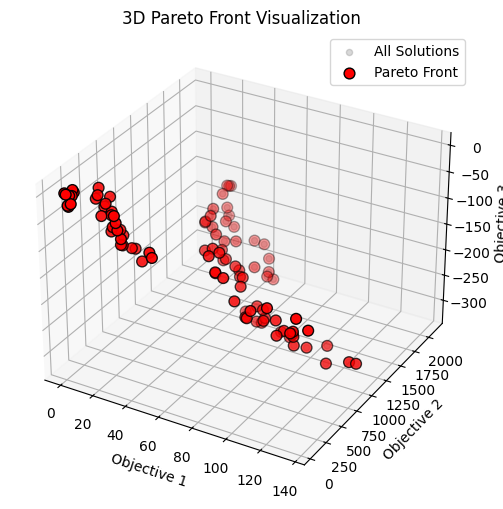

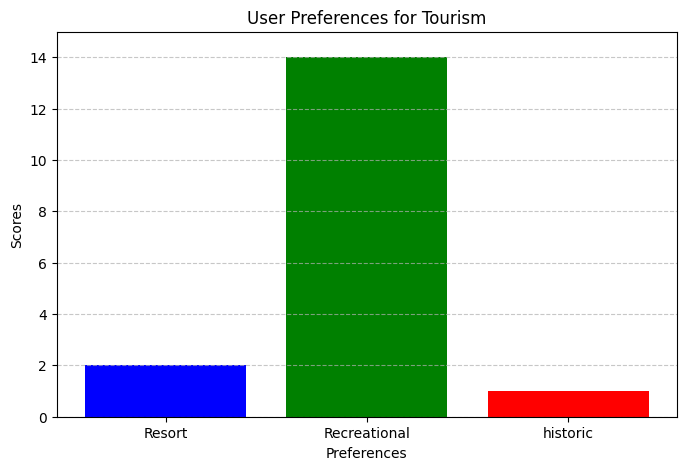

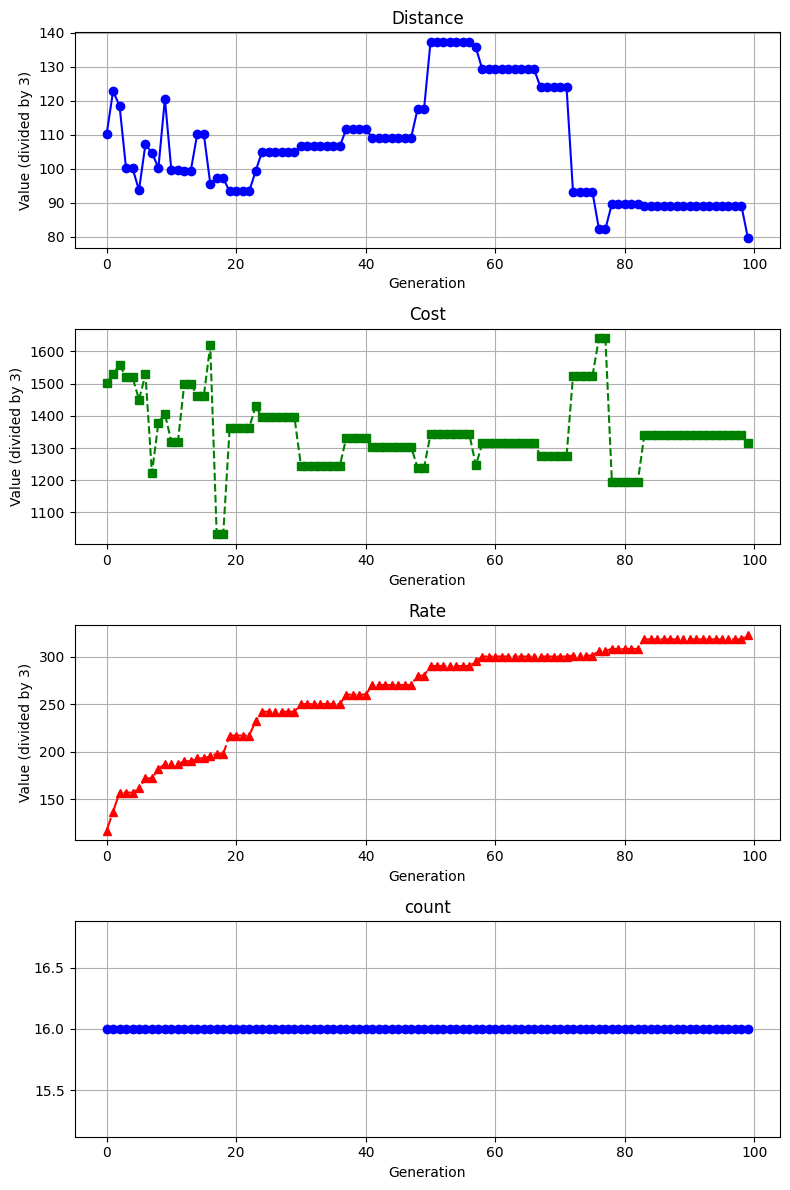

In [47]:
from os import replace
import random
import numpy as np
import folium
import matplotlib.pyplot as plt
import math
import ast

from pymoo.core.crossover import Crossover
from pymoo.core.problem import Problem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.population import Population
from pymoo.core.crossover import Crossover
from pymoo.operators.selection.rnd  import RandomSelection
from pymoo.core.sampling import Sampling
from geopy.distance import geodesic
from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
from pymoo.core.callback import Callback
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.core.selection import Selection
from pymoo.visualization.scatter import Scatter
from pymoo.core.mutation import Mutation
from mpl_toolkits import mplot3d
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from mpl_toolkits.mplot3d import Axes3D



def repairSolution(solution):
   solution = [int(row) for row in solution]
   return solution


def isValidSolution(solution):
   solution = [int(row) for row in solution]
   return True




def createSolution(n_var, maxSamping):
    sample = [0 for _ in range(n_var)]

    rand = random.randint(2, maxSamping)
    sample[0] = rand

    hotel = locations[locations["type"] == "hotel"].sample(n=1)
    hotelId = hotel["Id"].values[0]
    sample[1] = hotelId
    sample[rand] = hotelId

    for i in range(2, rand):
      location = locations[locations["type"] != "hotel"].sample(n=1)
      sample[i] = location["Id"].values[0]


    return sample


class ValidatePopulationCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = []  # نگه‌داشتن تاریخچه جمعیت‌های معتبر

    def notify(self, algorithm):
        # ترکیب والدین و فرزندان
        combined_population = np.vstack([algorithm.pop.get("X"), algorithm.off.get("X")])

        # اصلاح جمعیت جدید
        new_population = np.zeros_like(combined_population)  # جمعیت جدید اصلاح‌شده

        for i in range(len(combined_population)):
            # اصلاح هر فرد از جمعیت
            individual = combined_population[i]

            # اصلاح فرد با استفاده از روش‌های مورد نظر (مثلاً ایجاد یک راه‌حل معتبر)
            # فرض کنید تابع اصلاحی createValidSolution این کار را انجام می‌دهد
            individual = self.repair_individual(individual)

            # اصلاح فرد در جمعیت جدید
            new_population[i] = individual
        F = np.zeros((new_population.shape[0], algorithm.problem.n_obj))
        algorithm.problem._evaluate(new_population, out={"F": F})




        # به روز رسانی جمعیت با جمعیت اصلاح‌شده
        # اطمینان از هم‌خوانی اندازه جمعیت
        if new_population.shape[0] == algorithm.pop.size:
            algorithm.pop.set("X", new_population)
        else:
            # اگر تعداد تغییر کرده، تعداد جمعیت را مطابق با نیاز تنظیم کنید
            algorithm.pop.set("X", new_population[:algorithm.pop.size])


    def repair_individual(self, individual):
        if(isValidSolution(individual) == False):
            individual = repairSolution(individual)
        return individual



n_obj = 3
best_per_generation = []  # لیستی برای هر تابع هدف


counts = []

class BestPopCallback(Callback):
    def __init__(self, n_obj):
        super().__init__()
        self.n_obj = n_obj

    def notify(self, algorithm):
        global best_per_generation
        global counts
        if algorithm.pop is not None:
            F = algorithm.pop.get("F")  # مقادیر تابع هدف
            X = algorithm.pop.get("X")
            # best_idx = np.argmin(F[:, 2])  # پیدا کردن بهترین مقدار بر اساس هدف اول
            best_idx = np.argmin(F[:, 2])
            per_generation = [[] for _ in range(n_obj)]
            per_generation[0] = F[best_idx, 0]
            per_generation[1] = F[best_idx, 1]
            per_generation[2] = abs(F[best_idx, 2])
            best_per_generation.append(per_generation)
            counts.append(X[best_idx][0])

            # fig = plt.figure(figsize = (10, 7))
            # ax = plt.axes(projection ="3d")

            # # Creating plot
            # ax.scatter3D(F[:, 0], F[:, 1], F[:, 2], color = "green")
            # plt.title("simple 3D scatter plot")

            # # show plot
            # plt.show()

            # pareto_indices = NonDominatedSorting().do(F, only_non_dominated_front=True)
            # pareto_front = F[pareto_indices]

            # fig = plt.figure(figsize=(8, 6))
            # ax = fig.add_subplot(111, projection='3d')

            # ax.scatter(F[:, 0], F[:, 1], F[:, 2], label="All Solutions", color="gray", alpha=0.3)
            # ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], label="Pareto Front", color="red", edgecolor="black", s=60)

            # ax.set_xlabel("Objective 1")
            # ax.set_ylabel("Objective 2")
            # ax.set_zlabel("Objective 3")
            # ax.set_title("3D Pareto Front Visualization")
            # ax.legend()
            # plt.show()

class CustomMutation(Mutation):
    def __init__(self, mutation_rate=0.1):
        super().__init__()
        self.mutation_rate = mutation_rate  # احتمال جهش

    def _do(self, problem, X, **kwargs):
        X_mutated = X.copy()
        n, d = X.shape  # تعداد کروموزوم‌ها و متغیرها

        for i in range(n):
            if np.random.rand() < self.mutation_rate:
                if X_mutated[i, 0] > 2:
                  j = np.random.randint(2, X_mutated[i, 0])  # انتخاب یک ژن تصادفی برای تغییر
                  X_mutated[i, j] = getLocation()

        return X_mutated

class TournamentSelection(Selection):
    def __init__(self, tournament_size=2):
        super().__init__()
        self.tournament_size = tournament_size

    def _do(self, problem, pop, n_select, n_parents=1, **kwargs):
        selected = np.full((n_select, n_parents), -1, dtype=int)

        for i in range(n_select):
            for j in range(n_parents):
                # انتخاب کاندیداها به صورت تصادفی
                candidates = np.random.choice(len(pop), self.tournament_size, replace=True)
                # مقایسه کاندیداها بر اساس fitness (مقدار F)
                best = candidates[np.argmin([(pop[c].F[2]) for c in candidates])]
                selected[i, j] = best

        return selected




class CustomSampling(Sampling):
    def __init__(self, maxSampling=None, **kwargs):
        super().__init__(**kwargs)
        self.maxSampling = maxSampling

    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.n_var  # تعداد متغیرها
        xl = problem.xl        # حد پایین متغیرها
        xu = problem.xu        # حد بالا متغیرها
        samples = np.zeros([n_samples, n_var], dtype=int)
        maxSamping = self.maxSampling

        for row in range(len(samples)):
            samples[row] = createSolution(n_var, maxSampling)

        # print("Initial Population:")
        # df = pd.DataFrame(samples)
        # display(df)
        # print('---------------------')

        return samples


def getObjective(routes, prefernces):
    total_distance = []
    total_cost = []
    total_rate = []


    for route in routes:

        countHotel = 0
        route = route.astype(int)
        distance = 0
        cost = 0
        rate = 0

        # calculate distance
        for i in range(1, route[0]):
            start, end = int(route[i]), int(route[i + 1])

            start = locations[locations["Id"] == start]
            end = locations[locations["Id"] == end]

            start_lat, start_lon = start["Latitude"].values[0], start["Longitude"].values[0]
            end_lat, end_lon = end["Latitude"].values[0], end["Longitude"].values[0]

            distance += np.float64(geodesic((start_lat, start_lon), (end_lat, end_lon)).km)


        # caculate rate
        for i in range(1, route[0]):
          node = locations[locations["Id"] == route[i]]
          tags = node["tag"].values[0]

          tags = tags.replace("[" ,"")
          tags = tags.replace("'" ,"")
          tags = tags.replace(']', "")
          tags = tags.replace(' ', "")
          tags = tags.split(',')


          for tag in tags:
            if(tag in prefernces):
              rate -=  node["Stars"].values[0] * prefernces[tag]

          averageRate = rate / len(tags)

        # caculate cost
        for i in range(1, route[0]+1):
            node = locations[locations["Id"] == route[i]]
            cost += node["Price"].values[0]


        total_distance.append(distance)
        total_cost.append(cost)
        total_rate.append(averageRate)

    return (total_distance, total_cost, total_rate)


# مدل و الگوریتم NSGA-II
class HotelRouteProblem(Problem):
    def __init__(self, n_var, prefernces):


      super().__init__(n_var=n_var,
                         n_obj=3,
                         n_constr=0,
                         xl=0,
                         xu=len(locations) - 1,
                         type_var=int)



    def _evaluate(self, x, out, *args, **kwargs):
        total_distance, total_cost, total_rate = getObjective(x, prefernces)
        out["F"] = np.column_stack([total_distance, total_cost, total_rate])






class CustomeCrossover(Crossover):
    def __init__(self):

        super().__init__(2,2)

    def _do(self, problem, X, **kwargs):

        _, n_matings, n_var = X.shape
        Y = np.full_like(X, None, dtype=object)
        n_var -= 1
        for k in range(n_matings):
            while True:
              # انتخاب والدین
              parent1 = [int(item) for item in X[0, k]]
              parent2 = [int(item) for item in X[1, k]]


              lengthParent1 = parent1[0]
              lengthParent2 = parent2[0]




                # point = np.random.randint(2, minLength)

                # child1 = np.hstack((0,
                #                     parent1[1],
                #                     parent1[2:point],
                #                     parent2[point + 1:lengthParent2-1],
                #                     parent1[lengthParent1]))
                # child2 = np.hstack((0,
                #                     parent2[1],
                #                     parent2[2:point],
                #                     parent1[point + 1:lengthParent1-1],
                #                     parent2[lengthParent2]))

                # child1[0] = len(child1[1:])
                # child2[0] = len(child2[1:])

                # child1 = np.concatenate((child1, np.zeros(int((n_var - child1[0])) , dtype=child1.dtype)))
                # child2 = np.concatenate((child2, np.zeros(int((n_var - child2[0])) , dtype=child2.dtype)))
              child1 = parent1
              child2 = parent2

              break

            # print(f"parent1: , {parent1}")
            # print(f"parent2: , {parent2}")
            # print(f"child1: , {child1}")
            # print(f"child2: , {child2}")
            # print('-------------------')
            # ذخیره فرزندان
            Y[0, k] = child1
            Y[1, k] = child2

        return Y





selection  = TournamentSelection(tournament_size=3)


callback = BestPopCallback(3)
maxSampling=20

algorithm = NSGA2(pop_size=100,
                  sampling=CustomSampling(maxSampling=maxSampling),
                  crossover=CustomeCrossover(),
                  callback=callback,
                  mutation=CustomMutation(mutation_rate=0.3),
                  )




userPreference = {"historical": 5,
                  "Recreational": 4,
                  "Natural": 0.1,
                  "Adventure": 0.1,
                  "Religious": 0.1,
                  "Resort": 1,
                  "Artistic": 1,
                  "Photography": 3,
                  "Cultural": 0.1}



problem = HotelRouteProblem(n_var=50, prefernces=userPreference)
res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               verbose=True)






best_index = np.argmin(res.F[:, 2])






best_route = res.X[best_index].astype(int)
best_distance = res.F[best_index, 0]
best_cost = res.F[best_index, 1]
best_rate = res.F[best_index, 2]



print('---------------')
print("Best Route (order of locations):", best_route)
print("Best Distance:", best_distance)
print("Best Cost:", best_cost)
print("Best rate:", abs(best_rate))



# plot = Scatter()
# plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
# plot.add(res.F, facecolor="none", edgecolor="red")
# plot.show()




# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")

# # Creating plot
# ax.scatter3D(res.F[:, 0], res.F[:, 1], res.F[:, 2], color = "red")
# plt.title("simple 3D scatter plot")

# # show plot
# plt.show()
pareto_indices = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
pareto_front = res.F[pareto_indices]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(res.F[:, 0], res.F[:, 1], res.F[:, 2], label="All Solutions", color="gray", alpha=0.3)
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], label="Pareto Front", color="red", edgecolor="black", s=60)

ax.set_xlabel("Objective 1")
ax.set_ylabel("Objective 2")
ax.set_zlabel("Objective 3")
ax.set_title("3D Pareto Front Visualization")
ax.legend()
plt.show()







routePrefence = {}

for i in range(1, best_route[0]+1):
  location = locations[locations["Id"] == best_route[i]]

  tags = location["tag"]
  for index, values in tags.items():
    value = values
    value = value.replace("[" ,"")
    value = value.replace("'" ,"")
    value = value.replace(']', "")
    value = value.replace(' ', "")
    value = value.split(',')
    for item in value:
      if(item in routePrefence):
          routePrefence[item] += 1
      else:
          routePrefence[item] = 1






labels = list(routePrefence.keys())
values = list(routePrefence.values())

# رسم نمودار میله‌ای
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['b', 'g', 'r', 'c', 'm'])

# تنظیمات نمودار
plt.xlabel("Preferences")
plt.ylabel("Scores")
plt.title("User Preferences for Tourism")
plt.ylim(0, 15)  # تنظیم محدوده امتیازات
plt.grid(axis='y', linestyle='--', alpha=0.7)

# نمایش نمودار
plt.show()




data_divided = np.array(best_per_generation)

# ایجاد ۳ نمودار در یک figure
fig, axes = plt.subplots(4, 1, figsize=(8, 12))

# نمودار اول برای هدف ۱
axes[0].plot(data_divided[:, 0], marker='o', linestyle='-', color='b')
axes[0].set_title("Distance")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Value (divided by 3)")
axes[0].grid(True)

# نمودار دوم برای هدف ۲
axes[1].plot(data_divided[:, 1], marker='s', linestyle='--', color='g')
axes[1].set_title("Cost")
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Value (divided by 3)")
axes[1].grid(True)

# نمودار سوم برای هدف ۳
axes[2].plot(data_divided[:, 2], marker='^', linestyle='-.', color='r')
axes[2].set_title("Rate")
axes[2].set_xlabel("Generation")
axes[2].set_ylabel("Value (divided by 3)")
axes[2].grid(True)




axes[3].plot(counts, marker='o', linestyle='-', color='b')
axes[3].set_title("count")
axes[3].set_xlabel("Generation")
axes[3].set_ylabel("")
axes[3].grid(True)
# فاصله بین نمودارها را تنظیم کنیم تا خواناتر باشند
plt.tight_layout()
plt.show()




In [31]:
import folium

# ایجاد یک نقشه در مرکز اولین مکان
map_center = [locations["Longitude"].mean(), locations["Latitude"].mean()]
mymap = folium.Map(location=map_center, zoom_start=13)

for key in range(1, best_route[0]):

    location = locations[locations["Id"] == best_route[key]]
    color = 'blue'

    if('historic' in location["tag"].values[0]):
      color = 'red'
    if('Photography' in location["tag"].values[0]):
      color = 'orange'

    folium.Marker(
        location=[location["Longitude"].values[0], location["Latitude"].values[0]],
        popup= location["tag"].values[0],
        tooltip=f"{location['name'].values[0]}",
        icon=folium.Icon(color=color)
    ).add_to(mymap)


mymap




الگوریتم فازی - برای هر هتل سه مقدار بدبینانه،خوش بینانه و متوسط رو در نظر می گیریم

In [ ]:
import requests

# API Key خود را اینجا وارد کنید
API_KEY = '3k_wLMNf6CwujHWVLSLnoZFLnuDLAkzBrLxfZU9GT5cG2tkgngTk3YcAD80AUOTE665dznOmk1LXWbVHFvtBehmk-ao0Dnzo7urxabgbhvXWcDzWSRNWfvoXm-cDZ3Yx'

# URL پایه برای درخواست‌ها
url = 'https://api.yelp.com/v3/businesses/SoSQhqqOaS10aUuxDr1YtA'

# سربرگ‌ها (Headers) با کلید API
headers = {
    'Authorization': f'Bearer {API_KEY}',
}

# پارامترهای جستجو (می‌توانید موقعیت جغرافیایی، نوع کسب‌وکار و غیره را مشخص کنید)
params = {
    # 'term': 'hotels',   # نوع کسب‌وکار
    'location': 'New York',  # مکان
    'limit': 5               # تعداد نتایج
}

# ارسال درخواست به Yelp API
response = requests.get(url, headers=headers, params=params)

# بررسی وضعیت درخواست و چاپ نتایج
if response.status_code == 200:
    data = response.json()
    businesses = data.get('businesses')
    print(businesses)
    # for business in businesses:
    #     print(f"Name: {business['name']}, Rating: {business['rating']}, Address: {', '.join(business['location']['display_address'])}")
else:
    print(f"Error: {response.status_code}, {response.text}")


In [ ]:
filtered_df = locations[locations['tag'].apply(lambda x: 'restaurant')]
filtered_df

,Unnamed: 0,name,name:en,tag,type,Latitude,Longitude,Id,Stars,Price
603,603,خانه سنتی پرهامی,Parhami Traditional Hostel,"['restaurant', 'Resort']",restaurant,52.548575,29.610513,603,5,35
657,657,عمارت فیل,House of Elephant,"['restaurant', 'Resort']",restaurant,52.550227,29.611304,657,4,80
660,660,هتل سنتی آنا,Ana Traditional Hotel,"['restaurant', 'Resort']",restaurant,52.549947,29.608176,660,5,44
674,674,اقامتگاه سنتی ایران مهر,Iranmehr Boutique Hotel,"['restaurant', 'Resort']",restaurant,52.546682,29.614183,674,4,153
694,694,هتل عمارت قاجاریه,Ghajarieh Hotel,"['restaurant', 'Resort']",restaurant,52.545907,29.608112,694,1,168
706,706,خانه سنتی ملک,Malek Traditional House,"['restaurant', 'Resort']",restaurant,52.548940,29.610559,706,1,58
713,713,سرای آناهیتا,Anahita House,"['restaurant', 'Resort']",restaurant,52.547054,29.614590,713,2,73
